In [2]:

import numpy as np
import matplotlib.pyplot as plt
import joblib
import control as ctr


## Change trigger ID in later function
def upload_file(data_folder, filename):
    """
    upload SPAD binary file and retrieve timestamps and addreses of each tag in two separate tables 
    """
    global a
    fh =np.fromfile(data_folder+filename,dtype =np.uint8)
    fh1= np.array(fh.reshape(-1,4))
    print(fh1[:8,:])
    fh2 = np.array(np.fliplr(fh1))
    fh3 = np.unpackbits(fh2[1:-1,:]).reshape(-1,32)

    addr = np.array(np.fliplr(fh3[:,0:6]))
    timestamp = np.array(np.fliplr(fh3[:,6:]))
    val_addr = np.packbits(addr,axis=1,bitorder='little')-32
    val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
    val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                    2**24*val_timestamp[:,3]
    return(val_addr,val_timestamps)
def detector_intensity(val_addr):
    """
    Check intensity of each detector and triggers(position 23 and 24 in return table)
    """
    
    return(np.unique(val_addr, return_counts=True)[1])


def time_unwrap(val_timestamps):
    """
    Unwrap timestamps into one nondecresing series 
    """
    a=val_timestamps.shape[0]
    val_time =val_timestamps.astype('int64')
    for i in range(a-1):
        if val_time[i+1]-val_time[i]<-1*2**25:
            val_time[i+1:]+=2**26

    return(val_time)
def histogram_creation(val_addr,val_time,time_range):
    """
    Creates g2 correlation histogram
    middle row(position time_range)-tags in the same time
    time_range-maximum registered tag difference
    
    """
    a=val_time.shape[0]
    hist = np.zeros((23,23,2*time_range+1))
    for i in range(a-1):
        b=1    
        diff = val_time[i+b]-val_time[i]

        while diff<=time_range and diff>=0:
            if val_addr[i]<25 and val_addr[i+b]<25:
                hist[val_addr[i],val_addr[i+b],time_range+diff]+=1
                hist[val_addr[i+b],val_addr[i],time_range-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break
    return(hist)
def calc_correction(mode='create', channels=23,hist=[],counts_detec=[],filename=''):
    """
    mode create - calculate correction parameters and save it in pkl file
    mode upload - upload correction parameters from pkl file
    """
    if mode =='create':
        correction = np. zeros((channels,channels))
        correction_extra  = np. zeros((18,3))
        for i in range(channels):
            for j in range(channels):
                if i!=j:
                    correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
                if i+5==j:

                    correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
        joblib.dump((correction,correction_extra),filename)
        return(correction,correction_extra)
    elif mode == 'upload':
        (correction,correction_extra) =joblib.load(filename)
        return(correction,correction_extra)
def histogram_correction(hist,correction,correction_extra,counts_detec,middle_row):
    """
    Correct histograms using near 0 delay correction parameters
    
    """
    hist_corrected = np.copy(hist)
    for i in range(23):
        for j in range(23):
            if i!=j:
                hist_corrected[i,j,middle_row] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
            if i+5==j:
                hist_corrected[i,j,middle_row+1] -=(counts_detec[i])*correction_extra[i,0]
                hist_corrected[j,i,middle_row-1] -=(counts_detec[i])*correction_extra[i,0]            
                hist_corrected[i,j,middle_row+2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[j,i,middle_row-2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[i,j,middle_row+3] -=(counts_detec[i])*correction_extra[i,2]
                hist_corrected[j,i,middle_row-3] -=(counts_detec[i])*correction_extra[i,2]
    return(hist_corrected)

def scan_points(val_addr,x_points,y_points):
    """
    finding triggers inside tags list and return list of all tags as numpy array
    ok
    """

    a = len(val_addr)
    pixels = np.zeros((y_points,x_points))
    lines = np.where(val_addr==234)[0]

    if lines.shape ==(0,):
        lines = np.array([0,a])
    else:
        lines =np.concatenate((lines,[a]))
    for i in range(y_points):
        part = val_addr[lines[i]:lines[i+1]]
        pix = np.concatenate(([0],np.where(part==233)[0],[lines[i+1]-lines[i]]))
        print(pix)
        if i%2==0:
            pixels[i] = lines[i] + pix[:-1]
        else:
            pixels[i] = lines[i] + np.flip(pix[:-1])
    return(pixels,lines)


def counts_scan(val_addr,val_timestamps,pixels,dwell_time,skip=0):
    """
    return number of counts of every detector/every pixel in desired dwell time
    dwell time in miliseconds
    """
    dwell_time = int(dwell_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((x,y,23))
    for i in range(x+skip):
        print('line',i)
        for j in range(y):
            
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        counts[i,j,val_addr[int(pixels[i,j]+delta)]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        counts[i,y-1-j,val_addr[int(pixels[i,y-1-j]+delta)]] += 1
                    delta += 1

    return(counts)

def counts_scan_binned(val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    dwell_time = int(dwell_time * 1e5)
    bin_time = int(bin_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((int(np.ceil(dwell_time/bin_time)),x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            delta= 0
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,j])+delta]- val_timestamps[int(pixels[i,j])])/bin_time))
                        counts[bin_number,i,j,val_addr[int(pixels[i,j])+delta]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,y-1-j])+delta]- val_timestamps[int(pixels[i,y-1-j])])/bin_time))
                        counts[bin_number,i,y-1-j,val_addr[int(pixels[i,y-1-j])+delta]] += 1
                    delta += 1
    return(counts)


def counts_scan_binned_add(counts,val_addr,val_timestamps,pixels,dwell_time,bin_time,x,y):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    Add result to existing counts table
    """

    counts1 = np.zeros(1,(np.ceil(dwell_time/bin_time),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            while val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]]<dwell_time:
                bin_number = np.floor(val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]])
                counts1[0,bin_number,i,j,val_addr[pixels[i,j]+delta]] += 1
                delta += 1
    counts = np.concatenate((counts,counts),axis = 0)
    return(counts)        
        
def histogram_plot(val_addr):
    """
    Create a detector heat map for certain range of tags
    """
    pos = np.zeros((val_addr.shape[0],2))
    for i in range(val_addr.shape[0]):
        if i%1e6==0:
            print(i)
        temp=val_addr[i]
        if temp<25:
            if temp<=4:
                pos[i,0]=np.sqrt(3)
                pos[i,1] = temp-2.
            elif temp<=8:
                pos[i,0]=np.sqrt(3)/2.
                pos[i,1] = temp-6.5            
            elif temp<=13:
                pos[i,0]=0
                pos[i,1] = temp-11. 
            elif temp<=17:
                pos[i,0]=-np.sqrt(3)/2.
                pos[i,1] = temp-15.5  
            elif temp<=23:
                pos[i,0]=-np.sqrt(3)
                pos[i,1] = temp-20.
    plt.hexbin(pos[:,1],pos[:,0],gridsize=(4,2))
    plt.colorbar()
    plt.show()
    return(pos)

def counts_binned(val_addr,val_timestamps,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    bin_time = int(bin_time * 1e5)
    max_time = max(val_timestamps)
    counts = np.zeros((int(np.ceil(max_time/bin_time)),23))

    for i  in range(len(val_addr)):
        if val_addr[i]<25:
            bin_number = int(np.floor((val_timestamps[i])/bin_time))
            counts[bin_number,val_addr[i]] += 1
           
    return(counts)


(correction,correction_extra)= joblib.load('correction_parameters_laser.pkl')

[[255 255 255 239]
 [  8  74   0 128]
 [181 182   0 128]
 [134 216   0 128]
 [ 82 234   0 128]
 [ 52 154   1 128]
 [125 238   1 128]
 [228  37   2 128]]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in uint_scalars
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in uint_scalars


0


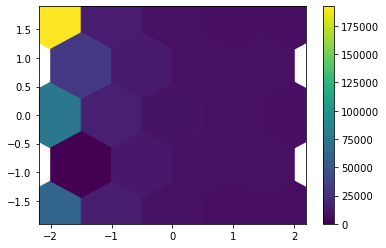

In [2]:
# Processing single pixel data for G2 measurement
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.07/",filename = "bead_calibration_06_07_2020_v1")
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
#correction,correction_extra=calc_correction(mode='upload', channels=23,hist=[],counts_detec=[],filename='correction_parameters_laser.pkl')
hist =  histogram_creation(val_addr,val_timestamps,time_range =100)
#hist_corrected = histogram_correction(hist,correction,correction_extra,counts_detec,100)
pos = histogram_plot(val_addr)

[      0   60104  123144  199557  302234  419681  543061  678430  777993
  855852  953933 1053382 1157322 1265383 1347312 1405555 1462576 1525979
 1598266 1675948 1752863 1823941]
[      0   70842  147481  250912  342770  406578  463809  537069  633437
  738854  853450  982190 1086196 1160835 1257917 1358940 1439507 1513519
 1604694 1708384 1804284 1892176]
[      0   86226  173254  259969  321564  365985  413916  470850  528146
  593917  691299  795204  881996  954981 1025523 1106040 1184689 1275890
 1404090 1528161 1619468 1715893]
[      0  126772  280928  427935  524220  627548  757904  856841  917680
  984238 1060074 1131399 1200484 1271400 1325366 1363840 1406653 1463569
 1532802 1596973 1647642 1696131]
[      0   50852  120020  208220  286277  335921  382371  445060  527958
  608591  668117  725008  784480  845169  924387 1046181 1170608 1249444
 1342074 1499515 1658794 1760308]
[      0  102906  233813  339004  413462  492936  603647  727218  826042
  891782  948703 1007398 10

In [ ]:
plt.plot(val_time)

In [456]:
#intensity scan analysis with time binning
#final data- (counts) intensity value of each pixel in every scan point binned 
# format :(x,y,detector)
# dwell and bin times in ms
nanoSPAD_X= 30
nanoSPAD_Y= 30
dwell_time = 200
bin_time = 0.1
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.08/",filename = "single_atto_647_18_8_AM_v5_5mhz_800nW_scan")
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y,skip_y =1)

#Counts variables(with/without binning)
counts = counts_scan(val_addr,val_time,points,dwell_time = dwell_time)
#counts_bin = counts_scan_binned(val_addr,val_time,points,dwell_time = dwell_time, bin_time = bin_time)

[[255 255 255 239]
 [254  27   0 128]
 [124  79   0 204]
 [124  79   0 128]
 [154  88   0 128]
 [242  88   0 128]
 [153  99   0 216]
 [ 71 123   0 128]]
[    0  2897  5784  8581 11374 14280 17201 20186 23342 26260 29148 31899
 34442 37085 39670 42215 44830 47400 50140 52918 55835 58852 61955 64957
 67891 70731 73395 75768 78151 80605 83142 85731]
[    0  2452  4901  7348  9795 12289 15037 17903 21084 24206 27207 30192
 33105 35897 38723 41444 44062 46656 49197 51763 54397 57048 59766 62462
 65081 67709 70291 72918 75575 78466 81296 84151]
[    0  2803  5274  7710 10212 12626 15079 17479 19988 22487 24955 27447
 29879 32349 34758 37150 39735 42305 45065 47890 50719 53573 56574 59591
 62466 65166 67670 70196 72693 75018 77396 79855]
[    0  2436  4778  7067  9470 11957 14573 17293 20027 22801 25695 28661
 31497 34354 37060 39613 42194 44724 47367 50020 52655 55222 57829 60308
 62685 64969 67245 69502 71854 74265 76679 79163]
[    0  2405  4841  7172  9426 11661 13945 16071 18329 20636 22

In [457]:
counts_bin = counts_scan_binned(val_addr,val_time,points,dwell_time = dwell_time, bin_time = bin_time)

line 0
line 1
line 2
line 3
line 4
line 5
line 6
line 7
line 8
line 9
line 10
line 11
line 12
line 13
line 14
line 15
line 16
line 17
line 18
line 19
line 20
line 21
line 22
line 23
line 24
line 25
line 26
line 27
line 28
line 29


In [ ]:
points

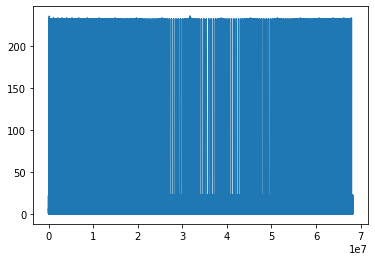

In [7]:
plt.plot(val_addr)


In [11]:
np.max(counts_bin)
print(2**7)

128


In [22]:
val_addr.max()

236

In [459]:
np.save("single_atto_647_18_8_AM_v5_5mhz_800nW_scan",counts_bin.astype('int16'))

In [41]:
#min dead time calculation(VQ=0.85V-approved by Michel to increase VQ until dead time is equal 50 ns)
#recommended in manual VQ= 0.75(left power supply ch 3)
for i in range(23):
    print(i,10*min(np.abs(100-np.where(hist[i,i,:]>0)[0])),'ns')

0 60 ns
1 70 ns
2 90 ns
3 70 ns
4 70 ns
5 90 ns
6 50 ns
7 110 ns
8 60 ns
9 70 ns
10 60 ns
11 80 ns
12 70 ns
13 80 ns


ValueError: min() arg is an empty sequence

In [40]:
# (G2 correction coefficient for laser)
correction = np. zeros((23,23))
correction_extra  = np. zeros((18,3))
for i in range(23):
    for j in range(23):
        if i!=j:
            correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
        if i+5==j:

            correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
            correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
            correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
joblib.dump((correction,correction_extra),'correction_parameters_laser.pkl')       

['correction_parameters_laser.pkl']

In [422]:
counts_bin.shape

(200, 30, 31, 23)

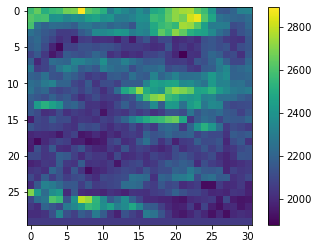

In [458]:


plt.imshow(counts_bin.sum(axis=(0,3)))
plt.colorbar()
plt.show()

0


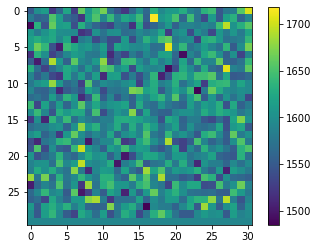

1


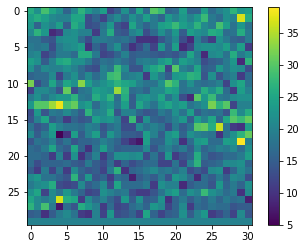

2


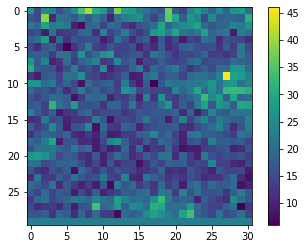

3


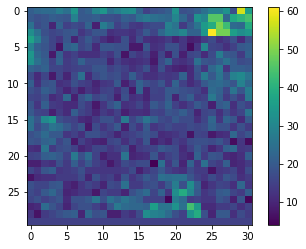

4


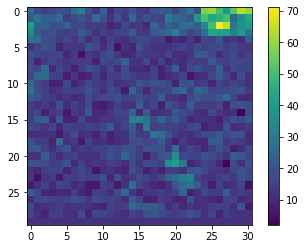

5


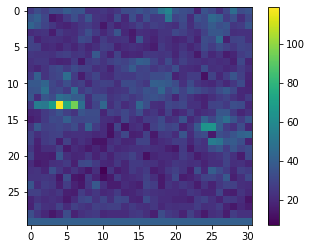

6


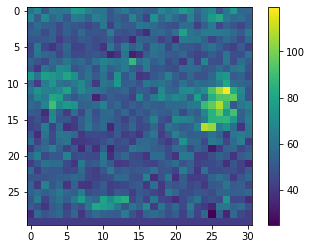

7


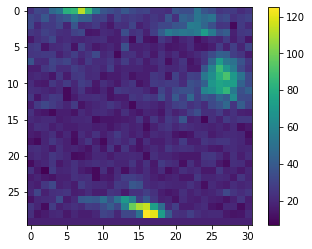

8


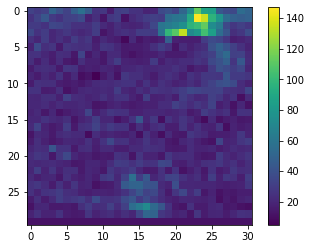

9


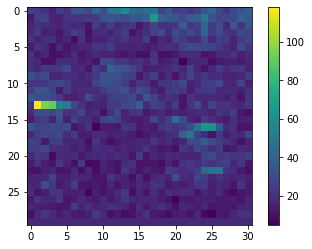

10


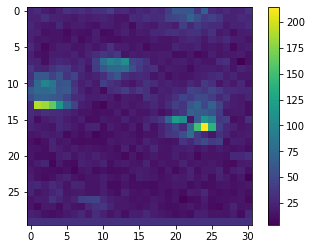

11


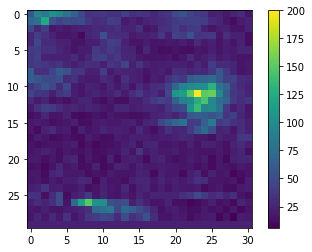

12


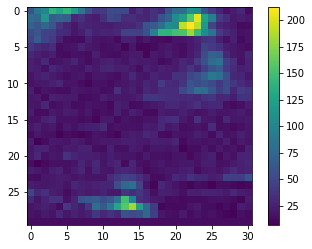

13


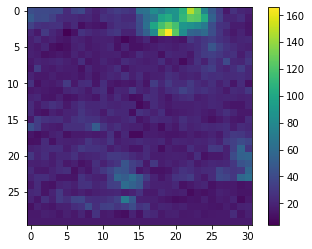

14


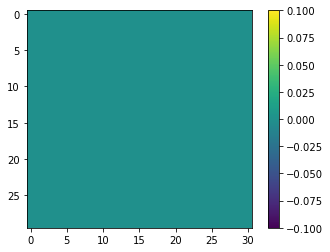

15


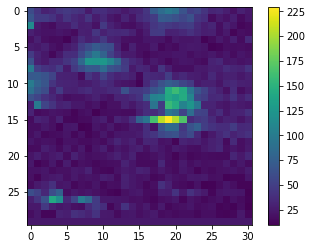

16


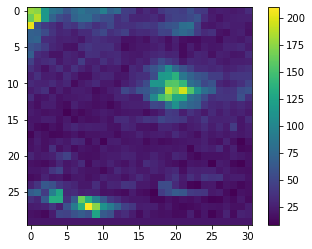

17


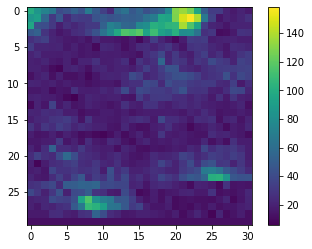

18


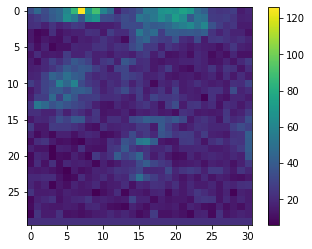

19


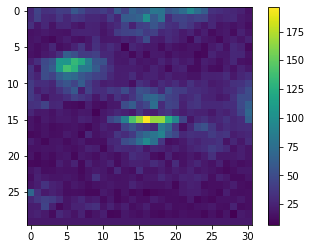

20


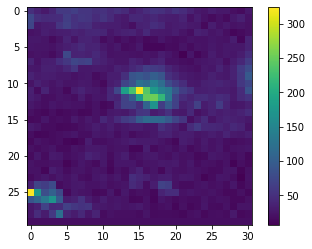

21


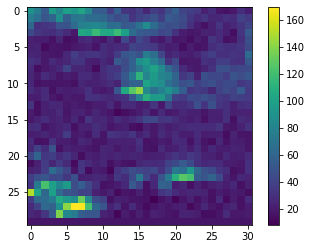

22


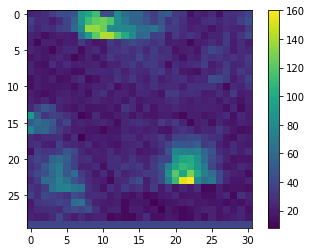

In [443]:
for i in range(23):
    print(i)
    plt.imshow(counts[:,:,i])
    plt.colorbar()
    plt.show()

In [59]:
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.09/",filename = "single_atto_647_01_9_AM_v9_80mhz_250nW_h2o")
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)

[[255 255 255 239]
 [ 77  59   0 128]
 [254  59   0 160]
 [ 27  69   0 128]
 [164 140   0 128]
 [188 168   0 192]
 [ 96  29   1 128]
 [222  42   1 128]]


In [60]:
val_addr.T[0].shape

(1434162,)

In [61]:
T=(time_unwrap(val_timestamps))
T=T[val_addr.T[0]!=0]

In [62]:
T.shape

(438448,)

Text(0.5, 0, 'Time[s]')

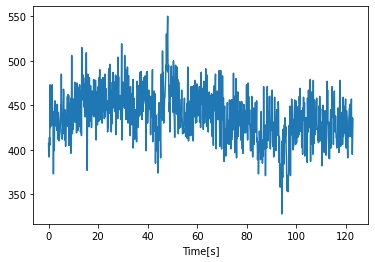

In [63]:
t1= np.histogram(T,bins = 1000)
plt.plot(np.linspace(0,T.max()*1e-8,1000),t1[0])
plt.xlabel('Time[s]')

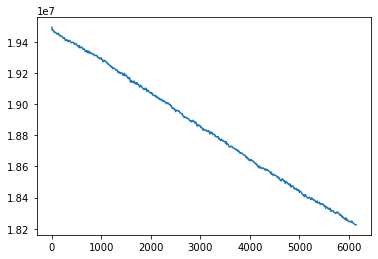

In [54]:
import scipy
N=10000
K=500
t1= np.histogram(T,bins = N)
plt.plot(np.linspace(0,K*T.max()/(N*100000),K),scipy.signal.correlate(t1[0],t1[0],mode='full')[N+1:N+K+1])

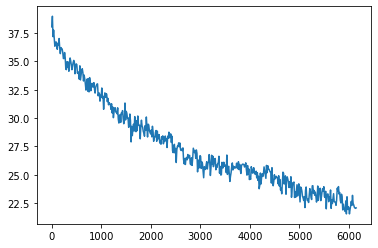

In [55]:
plt.plot(np.linspace(0,K*T.max()/(N*100000),K),[np.cov(t1[0][1+i:],t1[0][:-(i+1)])[0,1] for i in range(K)])

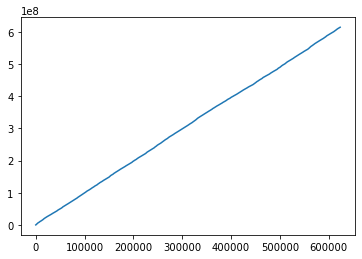

In [548]:
plt.plot((T//10).astype('uint32'))

In [549]:
TT=(T//10).astype('uint32')

In [544]:
(T)[-1]

6144002788

In [550]:
(TT[np.newaxis,:]-TT[:,np.newaxis]).shape

MemoryError: Unable to allocate 1.41 TiB for an array with shape (623174, 623174) and data type uint32

In [56]:
t0=0
v=[]
for t in T[T<(T[0]+6000000000)]:
    v.append(t-t0)
    t0=t
    
    #

In [57]:
T[T<(T[0]+1000000000)]*20/T.max()

array([1.42211960e-04, 3.56049920e-04, 5.88357938e-04, ...,
       1.62769311e+00, 1.62769311e+00, 1.62772015e+00])

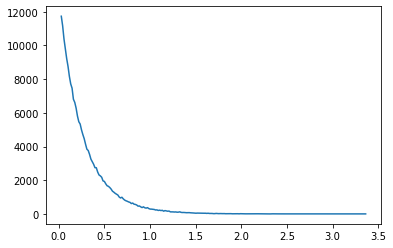

In [58]:
N_max=10000
H=np.histogram(v[1:],(np.shape(v)[0])//1000)
xdata=H[1][2:N_max+2]*10*1e-6
ydata=H[0][1:N_max+1]
plt.plot(xdata,ydata)

In [524]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [525]:
popt, pcov = curve_fit(func, xdata, ydata)

In [526]:
pcov

array([[1.98473168e+02, 1.26815116e-01, 5.72923473e-01],
       [1.26815116e-01, 1.70293871e-04, 8.89919053e-03],
       [5.72923473e-01, 8.89919053e-03, 3.37141420e+00]])

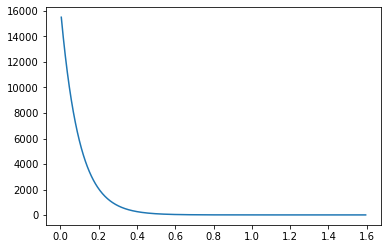

In [527]:
plt.plot(xdata,func(xdata,popt[0] , popt[1], popt[2]))

In [528]:
1/popt[1]

0.0964791149761476

In [293]:
1/popt[1]

0.45958543334777463

In [231]:
1/popt[1]

0.0355479274287026

In [91]:
T.max()*10*1e-9

20.480024750000002

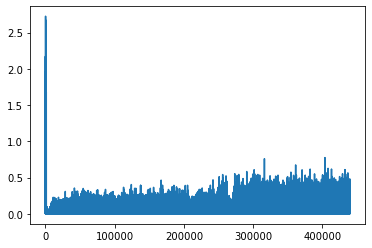

In [92]:
plt.plot(np.array(v)*20000/T.max())

In [93]:
np.histogram(v,1)

(array([439589], dtype=int64), array([-1.00000e+00,  2.79124e+05]))

In [252]:
len(val_addr)
print(67108862/37.549)

1787234.3338038297


In [253]:
hist = histogram_creation(val_addr,val_time,1)

In [94]:
c = counts_binned(val_addr,val_time,10)

In [95]:
c.shape

(2049, 23)

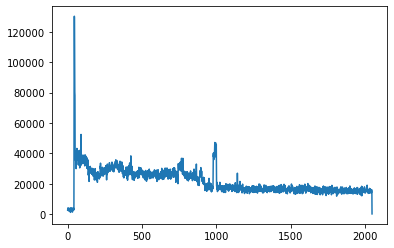

In [96]:
plt.plot((np.sum(c[:,1:],axis=1)*100))

In [11]:
counts_bin.shape

(300, 20, 21, 23)

In [75]:
m=700
A=np.zeros(m)

c1=c[0:750,1:]-c[0:750,1:].mean(axis=0)
N=c1.shape[0]
for i in range(m):
    A[i]=(c1[i:N]*c1[:N-i]).mean(axis=0).sum()

In [39]:
c1[i:N].shape

(0, 22)

In [40]:
i

2050

In [191]:
A.shape

(10000,)

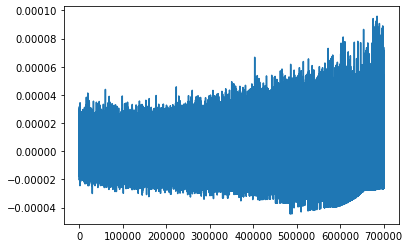

In [43]:
plt.plot(A[1:])

In [44]:
np.save("noise_vector_16_07",A.astype('float'))

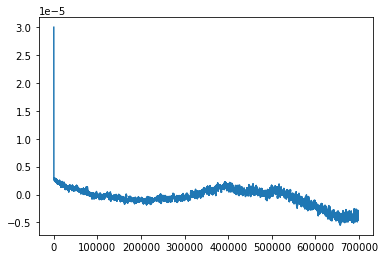

In [55]:
B = np.zeros(698000)
for a in range(698000):
    B[a] = np.mean(A[a:a+1000])
plt.plot(B)

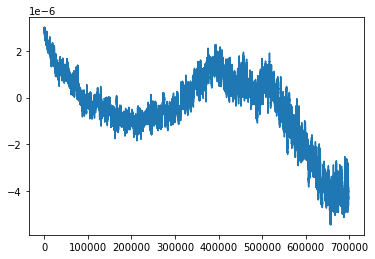

In [57]:
plt.plot(B[1:])

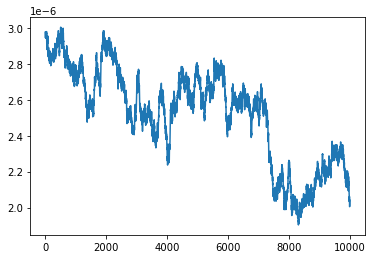

In [56]:
plt.plot(B[1:10000])

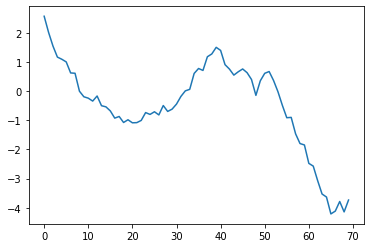

In [224]:
plt.plot(AA)

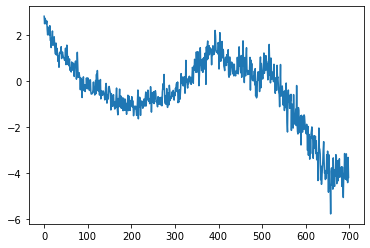

In [77]:
plt.plot(A[1:])

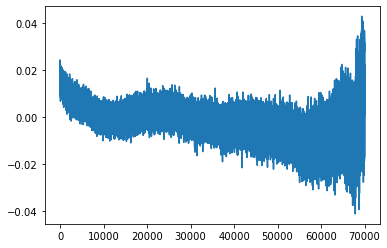

In [71]:
plt.plot(A[1:])

In [ ]:
700*10

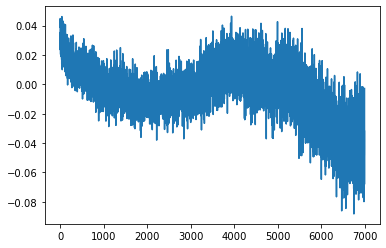

In [215]:
plt.plot(A[1:])

In [216]:
A.shape

(7000,)

In [219]:
A.shape[0]/100

70.0

In [223]:
AA=np.zeros(int(A.shape[0]/100))
for i in range(int(A.shape[0]/100)): 
    AA[i]=A[1+100*i:100*i+101].sum()

In [58]:
bbbb=np.zeros((1,aaaa.shape[0],aaaa.shape[1],aaaa.shape[2],aaaa.shape[3]+2))

In [59]:
bbbb[0,:,:,:,:-2]=aaaa

In [60]:
def rebin(scans, u=0):
    scans2=np.array([np.sum(scans[:,int(u*i):int(u*i+u),:,:,:],axis=1) for i in range(int(scans[0,:,:,:,0].shape[0]/u))])
    return np.transpose(scans2, (1,0,2,3,4))


In [50]:
aaaa=np.load('Adrian_v3_19_6_1uW_5Mhz.npy')

In [61]:
scans=rebin(bbbb,2)

In [62]:
np.save('scans_2',scans.astype('int16'))